In [1]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
IMAGE_SHAPE=(224,224)

In [15]:
import pathlib
data_dir=pathlib.Path("/home/sanjana/Desktop/med_img/cervical-cancer2")
data_dir

PosixPath('/home/sanjana/Desktop/med_img/cervical-cancer2')

In [16]:
image_count=len(list(data_dir.glob('*/*jpg')))
image_count

2145

In [17]:
lesions_dict={
    'NILM': list(data_dir.glob('NILM/*')),
    'LSIL': list(data_dir.glob('LSIL_new/*')),
    'HSIL': list(data_dir.glob('HSIL_new/*')),
    'SCC': list(data_dir.glob('SCC_new/*')),
}

In [18]:
lesions_dict_test={
    'NILM-test': list(data_dir.glob('NILM_test/*')),
    'LSIL-test': list(data_dir.glob('LSIL_test/*')),
    'HSIL-test': list(data_dir.glob('HSIL_test/*')),
    'SCC-test': list(data_dir.glob('SCC_test/*')),
}

In [19]:
lesions_labels={
    'NILM': 0,
    'LSIL': 1,
    'HSIL': 2,
    'SCC': 3,
}

In [20]:
lesions_labels_test={
    'NILM-test': 0,
    'LSIL-test': 1,
    'HSIL-test': 2,
    'SCC-test': 3,
}

In [21]:
x, y=[],[]
for lesions_name, images in lesions_dict.items():
    for image in images:
        img=cv2.imread(str(image))
        x.append(img)
        y.append(lesions_labels[lesions_name])

In [22]:
x_test=[]
y_test=[]
for lesions_name, images in lesions_dict_test.items():
    for image in images:
        img=cv2.imread(str(image))
        x_test.append(img)
        y_test.append(lesions_labels_test[lesions_name])

In [23]:
x=np.array(x)
y=np.array(y)

In [24]:
x_test=np.array(x_test)
y_test=np.array(y_test)

In [25]:
from sklearn.model_selection import train_test_split
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=1, shuffle=True)


In [26]:
x_train_scaled=x/255
x_test_scaled=x_test/255
x_val_scaled=x_val/255
print(len(x_train_scaled))
print(len(x_val_scaled))
print(len(x_test_scaled))

1200
123
122


In [27]:
y_train=y

In [28]:
classifier="https://tfhub.dev/google/efficientnet/b0/feature-vector/1"
mod=hub.KerasLayer(classifier, input_shape=(224,224,3), trainable=False)

In [29]:
from sklearn.model_selection import KFold

In [30]:
from tensorflow.python.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=2)

In [31]:
import matplotlib.pyplot as plt
acc_per_fold=[]
loss_per_fold=[]
num_lesions=4
# Define the K-fold Cross Validator
kfold = KFold(n_splits=2, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(x_train_scaled, y_train):
    model=tf.keras.Sequential([
        mod, 
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(num_lesions)
    ])

    model.compile(
        optimizer="adam", 
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['acc'])
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    history = model.fit(x_train_scaled, y_train, batch_size=20,epochs=10,callbacks = es)
    
    scores = model.evaluate(x_val_scaled, y_val, verbose=0)
    print(f'Score for fold (validation data) {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
60/60 [==============================] - 39s 516ms/step - loss: 0.3158 - acc: 0.8733
Epoch 2/10
60/60 [==============================] - 31s 519ms/step - loss: 0.0694 - acc: 0.9858
Epoch 3/10
60/60 [==============================] - 31s 517ms/step - loss: 0.0436 - acc: 0.9917
Epoch 4/10
60/60 [==============================] - 31s 519ms/step - loss: 0.0260 - acc: 0.9950
Epoch 5/10
60/60 [==============================] - 31s 521ms/step - loss: 0.0298 - acc: 0.9917
Epoch 6/10
60/60 [==============================] - 32s 525ms/step - loss: 0.0225 - acc: 0.9925
Epoch 7/10
60/60 [==============================] - 31s 519ms/step - loss: 0.0090 - acc: 0.9992
Epoch 8/10
60/60 [==============================] - 31s 521ms/step - loss: 0.0084 - acc: 0.9992
Epoch 9/10
60/60 [==============================] - 31s 518ms/step - loss: 0.0056 - acc: 0.9992
Epoch 10/10
60/60 [====================

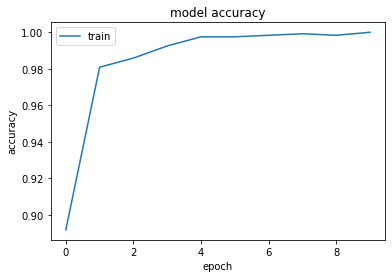

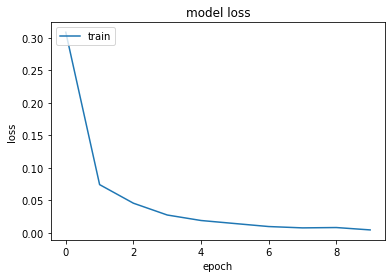

In [32]:
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [33]:
model.evaluate(x_test_scaled, y_test)

4/4 [==============================] - 5s 799ms/step - loss: 0.0208 - acc: 0.9918


[0.02080230787396431, 0.9918032884597778]

In [34]:
preds=model.predict(x_test_scaled)
pred_classes=np.argmax(preds, axis=1)
pred_classes

array([2, 3, 2, 2, 0, 1, 1, 1, 0, 2, 1, 0, 3, 0, 0, 2, 3, 2, 1, 0, 1, 3,
       2, 0, 2, 0, 2, 2, 0, 0, 0, 1, 0, 0, 0, 2, 0, 1, 2, 0, 1, 0, 1, 0,
       2, 1, 1, 0, 1, 0, 1, 0, 2, 0, 1, 2, 1, 0, 3, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 1, 1, 3, 0, 1, 2, 0, 2, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 3, 1, 0, 0, 2, 2, 0, 0, 1, 1, 1, 1, 2, 1, 0, 0, 2, 0, 1, 0,
       2, 1, 1, 2, 0, 1, 2, 1, 0, 1, 2, 0])

In [35]:
class_labels=[0,1,2,3]
import sklearn.metrics as metrics
report = metrics.classification_report(y_test, pred_classes, class_labels)
print(report) 
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred_classes)

/home/sanjana/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass labels=[0, 1, 2, 3] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        56
           1       1.00      1.00      1.00        32
           2       0.96      1.00      0.98        26
           3       1.00      0.88      0.93         8

    accuracy                           0.99       122
   macro avg       0.99      0.97      0.98       122
weighted avg       0.99      0.99      0.99       122



array([[56,  0,  0,  0],
       [ 0, 32,  0,  0],
       [ 0,  0, 26,  0],
       [ 0,  0,  1,  7]])